In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
biasMant = 1000 #10
biasExp = 6
vThresh = 10000

tauDecayV = 15

currentTimeConstant = 0 #round((1 / tauDecayC) * 2 ** 12)
voltageTimeConstant = round((1 / tauDecayV) * 2 ** 12)

# set neuron constants
currentDecay = 2 ** 12 - currentTimeConstant
voltageDecay = 2 ** 12 - voltageTimeConstant
actualThresh = vThresh * 2 ** 6

# set runtime parameters
current = 0
voltage = 0

# num timesteps processed
timeStep = 0

# reset voltage time
opacity = 0

# inject spike
spikeVal = 0
spikeWeight = 6400
spikesSoFar = 0

# inject random spike at rand % spikeSend 
spikeSend = 0

In [3]:
print('Voltage Decay: {}'.format(voltageDecay))

Voltage Decay: 3823


In [4]:
def step(opacity, voltage, current, spikeVal, spikeWeight, currentDecay, voltageDecay, biasMant, biasExp, actualThresh, spikesSoFar, timeStep):
    # update refractory time
    opacity -= .01
    if opacity <= 0:
        opacity = 0

    # inject spike at random timestep
    test = np.round(np.random.rand(1)[0]*1000, 3);
    if spikeSend != 0 and test % spikeSend == 0:
        spikeVal += 1

    # compute updated current
    inter1 = ((current * currentDecay) >> 12)
    current = inter1 + spikeVal*spikeWeight

    if current < 0:
        current = 0
    spikeVal = 0

    # compute updated voltage
    vInter = (voltage * voltageDecay) >> 12
    vInter += (current + (biasMant * (2 ** biasExp)))
    voltage = vInter;
    
    if voltage < 0:
        voltage = 0

    # check if neuron fired
    spiked = False
    if voltage > actualThresh:
        voltage = 0 # reset voltage
        opacity = 1 # add refractory time
        
        # update spike counts
        spikesSoFar += 1
        spiked = True
    

    # update timestep
    timeStep += 1
    
    return opacity, voltage, current, spikesSoFar, timeStep, spiked

In [5]:
voltage_arr = []
current_arr = []
spiked_arr = []

for _ in range(100):
    opacity, voltage, current, spikesSoFar, timeStep, spiked = step(opacity, voltage, current, spikeVal, spikeWeight, currentDecay, voltageDecay, biasMant, biasExp, actualThresh, spikesSoFar, timeStep)
    voltage_arr.append(voltage)
    current_arr.append(current)
    spiked_arr.append(spiked)

In [6]:
t = np.linspace(0, timeStep, timeStep) # original time axis

# interpolate time
from scipy.interpolate import interp1d
f2 = interp1d(t, voltage_arr, kind='previous')
t2 = np.linspace(0, timeStep, timeStep*1000) # interpolated time axis

Text(0.5, 1.0, '6 Spikes')

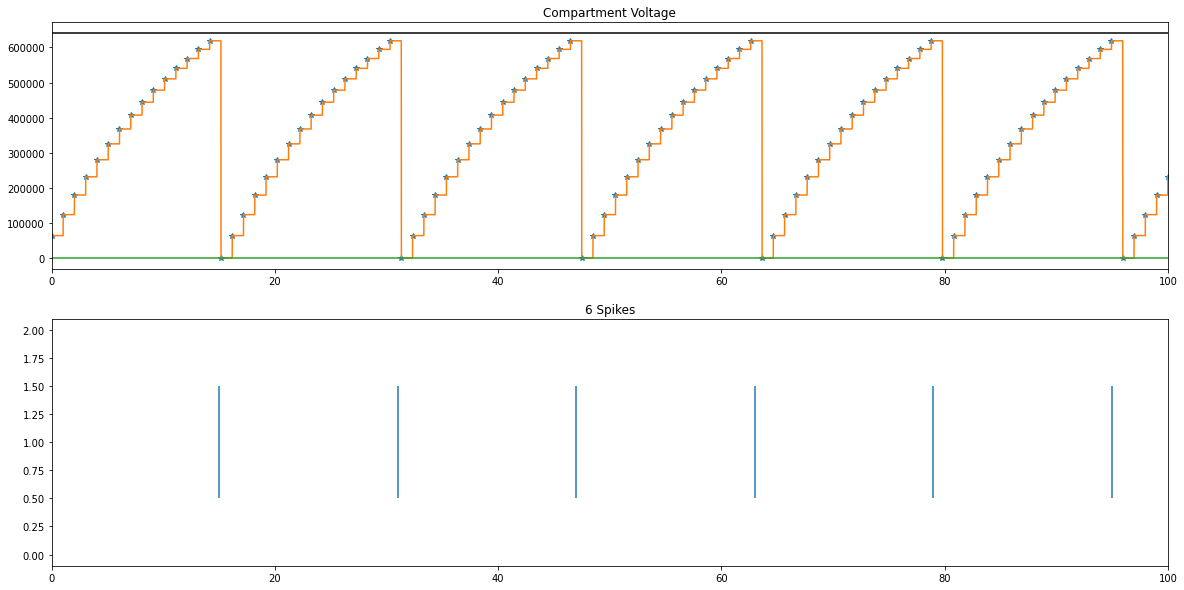

In [7]:
plt.figure(figsize=(20,10))
plt.subplot(211)
plt.plot(t, voltage_arr, '*')
plt.plot(t2, f2(t2))
plt.plot(t, current_arr)
plt.hlines(actualThresh, 0, timeStep)
plt.xlim(0, timeStep)
plt.title('Compartment Voltage')

plt.subplot(212)
plt.eventplot(np.where(spiked_arr))
plt.xlim(0, timeStep)
plt.title('{} Spikes'.format(spikesSoFar))